# Section 3.7 Example: analysis of a bioassay experiment.

I have followed the example in section 3.7 of Bayesian Data Analysis by Gelman et al (third edition, 2014). Below are my results  along with some comments. Look into the code to see the actual analysis.

When time allows I will build the bioassay example using `pymc3` following [this example](https://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter2_MorePyMC/Ch2_MorePyMC_PyMC3.ipynb#Example:-Challenger-Space-Shuttle-Disaster-).

First import the data which summarizes trials on 20 individuals.

In [13]:
import sec_3_7 as sec37
from scipy.integrate import simps
import warnings

# hide warnings in Python 2
warnings.simplefilter(action='ignore', category=UserWarning)

data, feature_names = sec37.get_data()

The the data is expanded to a form suited for logistic regression.

In [16]:
X, y = sec37.flatten_data(data)

As an exercise we group the data representing individuals back to the original summary form presented by Gelman et al. using pandas

In [17]:
grouped = sec37.group_data(X, y)
print(grouped)

      x  ndead  ntot  nalive  pdead
0 -0.86      0     5       5    0.0
1 -0.30      1     5       4    0.2
2 -0.05      3     5       2    0.6
3  0.73      5     5       0    1.0


Use `scikit-learn` to do logistic regression (MLE). Note that the default regularization has effectively been turned off.

In [18]:
dose, p_dead, x_ld50, _ = sec37.logit_sklean(X, y, feature_names)


*** sklearn ***
Coefficients
   Coef for Dose log g/ml 7.74871833754
   Intercept: 0.846554250746


Plot the result along with point estimates for the death probability at each dose

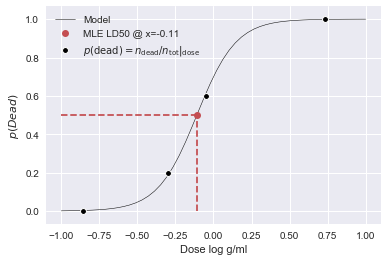

In [19]:
sec37.plot_logistic(dose, p_dead, grouped, x_ld50, estimate_type='MLE',
                    xlabel=feature_names[0], ylabel='$p(Dead)$')

As an exercise do the MLE using `statsmodels`

In [20]:
sec37.logit_statsmodels(X, y)


*** statsmodels ***
Optimization terminated successfully.
         Current function value: 0.294722
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   20
Model:                          Logit   Df Residuals:                       18
Method:                           MLE   Df Model:                            1
Date:                Tue, 14 May 2019   Pseudo R-squ.:                  0.5717
Time:                        14:15:33   Log-Likelihood:                -5.8944
converged:                       True   LL-Null:                       -13.763
                                        LLR p-value:                 7.280e-05
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             7.7488      4.873      1.590      0.112      -1.802      17.299
const   

array([7.74881715, 0.84658023])

Calculate the posterior density on a grid

In [21]:
(av, bv,
 density,
 a_vals, b_vals,
 delta_a, delta_b) = sec37.posterior_density_grid(data['Dose log g/ml'],
                                                  data['Number of animals'],
                                                  data['Number of deaths'],
                                                  na=500, nb=500)

Normalize the density to a probability distribution assuming constant value in each grid block. 

In [22]:
pdf_grid = sec37.make_pdf_grid(density, delta_a, delta_b)

Get the MAP estimate

In [23]:
idxs_map = pdf_grid.argmax()
map_estimate = av.ravel()[idxs_map], bv.ravel()[idxs_map]
print('MAP estimate (a, b)', map_estimate)

('MAP estimate (a, b)', (0.8617234468937873, 7.835671342685373))


Plot the density along with with MAP estimate

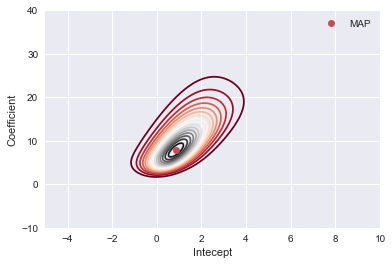

In [24]:
sec37.plot_posterior_density(av, bv, pdf_grid, map_estimate)

Integrate pdf to validate that we were in fact successful

In [25]:
print('Total posterior probability (validation):', simps(simps(pdf_grid, b_vals), a_vals))

('Total posterior probability (validation):', 0.9999913685930165)


Transform the density into a  multinominal grid

In [26]:
prob_grid = sec37.make_prob_grid(density)

Sum over all grid blocks to validate that we were successful

In [27]:
print('Total posterior probability (validation):', prob_grid.sum())

('Total posterior probability (validation):', 1.0)


Sample the grid to draw (a, b) values from the posterior. Plot the sampled values.

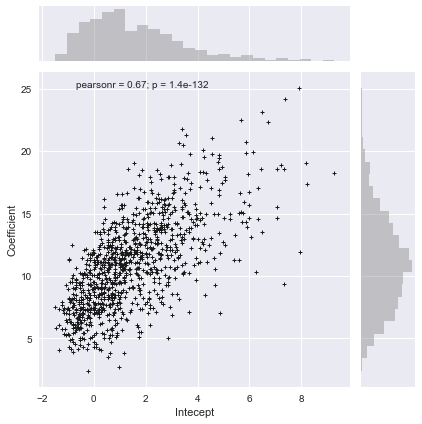

In [28]:
ab_vals = sec37.sample_posterior(a_vals, b_vals, prob_grid, nsamples=1000)
sec37.plot_posterior_samples(ab_vals[:,0], ab_vals[:,1])

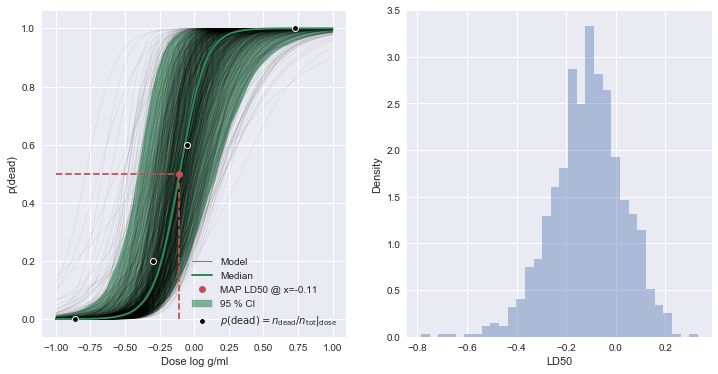

In [29]:
# Only use parameters where b>0 
ab_vals = ab_vals[ab_vals[:,1] > 0]

# LD50 histogram for b > 0
axs = sec37.plot_ld50_hist(ab_vals)

dose, p_dead = sec37.sample_model(ab_vals)
x_ld50_map = -map_estimate[0]/map_estimate[1]
sec37.plot_logistic(dose, p_dead, grouped, x_ld50_map,
                    estimate_type='MAP', alpha=0.1,
                    xlabel=feature_names[0], ylabel='p(dead)',
                    ax=axs[0])